# Small CNN Building

Using device: cuda
Epoch 1, Avg Loss: 0.1186
Epoch 2, Avg Loss: 0.0321
Epoch 3, Avg Loss: 0.0087
Epoch 4, Avg Loss: 0.0037
Epoch 5, Avg Loss: 0.0030
Epoch 6, Avg Loss: 0.0028
Epoch 7, Avg Loss: 0.0027
Epoch 8, Avg Loss: 0.0027
Epoch 9, Avg Loss: 0.0027
Epoch 10, Avg Loss: 0.0027
✅ Model saved to edge_detection/outputs/cnn_edge_model.pth


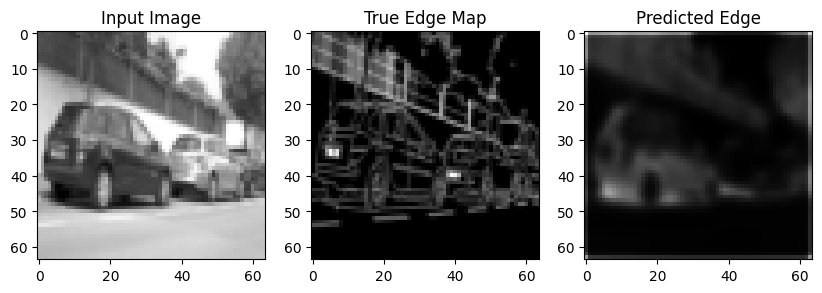

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob

# --- Ensure output folder exists ---
os.makedirs("edge_detection/outputs", exist_ok=True)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Custom Dataset ---
class EdgeDataset(Dataset):
    def __init__(self, img_dir, edge_dir, transform=None):
        self.img_files = sorted(glob(os.path.join(img_dir, "*")))
        self.edge_files = sorted(glob(os.path.join(edge_dir, "*")))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img = Image.open(self.img_files[idx]).convert("L")
        edge = Image.open(self.edge_files[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
            edge = self.transform(edge)
        return img, edge


# --- Transformations ---
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# --- Load Dataset (use only few images) ---
dataset = EdgeDataset(
    img_dir="D:\Projects\Markovate Assignment\Edge_Detection_(ComputerVision)_Optimization&Monitoring\Data\imgs\train\rgbr",
    edge_dir="Edge_Detection_(ComputerVision)_Optimization&Monitoring\Data\edge_maps",
    transform=transform
)

# Limit to few samples for small training
subset_size = min(200, len(dataset))  # train on 8 or fewer images
subset = torch.utils.data.Subset(dataset, range(subset_size))
train_loader = DataLoader(subset, batch_size=5, shuffle=True)

# --- Model ---
class SimpleEdgeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = SimpleEdgeCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Training Loop ---
for epoch in range(10):
    running_loss = 0.0
    for imgs, edges in train_loader:
        imgs, edges = imgs.to(device), edges.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, edges)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

# --- Save Model ---
torch.save(model.state_dict(), "edge_detection/outputs/cnn_edge_model.pth")
print("Model saved to edge_detection/outputs/cnn_edge_model.pth")

# --- Visualization ---
model.eval()
with torch.no_grad():
    sample_img, sample_edge = dataset[0]
    pred = model(sample_img.unsqueeze(0).to(device))
    pred = pred.cpu().squeeze().numpy()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title("Input Image")
plt.subplot(1,3,2)
plt.imshow(sample_edge.squeeze(), cmap='gray')
plt.title("True Edge Map")
plt.subplot(1,3,3)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Edge")
plt.show()

SOBEL and Canny Implementation
Comparsion classical vs. learned edges visually + via metrics.

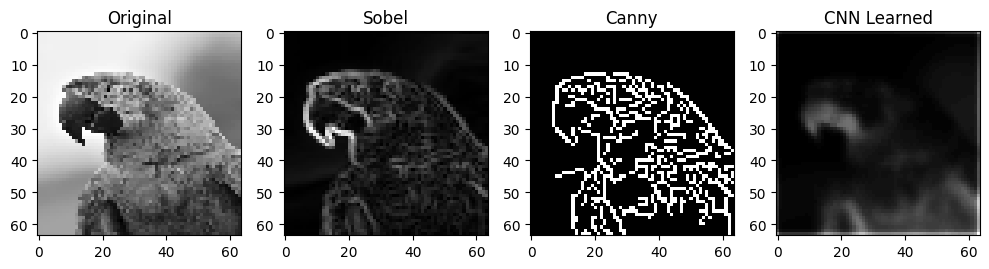

Saved visual comparison as 'edge_detection/outputs/edge_comparison.png'

=== Edge Detection Metric Comparison ===
Method             MSE      PSNR      SSIM
----------------------------------------
Canny            82.81      9.29     0.253
CNN              78.02     16.45     0.156


In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
#from cnn_edge_detection import SimpleEdgeCNN

# Load and preprocess image
img_path = "Edge_Detection_(ComputerVision)_Optimization&Monitoring\Test image\Test.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (64, 64))

# Classical edge detection
# Sobel
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = cv2.magnitude(sobelx, sobely)
sobel_edges = cv2.normalize(sobel_edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Canny
canny_edges = cv2.Canny(img, 100, 200)

# Load CNN model and run learned edges
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleEdgeCNN().to(device)
model.load_state_dict(torch.load("edge_detection/outputs/cnn_edge_model.pth", map_location=device))
model.eval()

# Convert image to tensor
tensor_img = torch.tensor(img / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    learned_edge = model(tensor_img).squeeze().cpu().numpy()

learned_edge = (learned_edge * 255).astype(np.uint8)

# Visual comparison
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1, 4, 2); plt.imshow(sobel_edges, cmap='gray'); plt.title("Sobel")
plt.subplot(1, 4, 3); plt.imshow(canny_edges, cmap='gray'); plt.title("Canny")
plt.subplot(1, 4, 4); plt.imshow(learned_edge, cmap='gray'); plt.title("CNN Learned")
plt.tight_layout()

# Save and show
plt.savefig("edge_detection/outputs/edge_comparison.png")
plt.show()

print("Saved visual comparison as 'edge_detection/outputs/edge_comparison.png'")

# Metric comparison (vs Sobel as reference)
def evaluate(ref, pred):
    mse_val = np.mean((ref - pred) ** 2)
    psnr_val = psnr(ref, pred, data_range=255)
    ssim_val = ssim(ref, pred, data_range=255)
    return mse_val, psnr_val, ssim_val

mse_canny, psnr_canny, ssim_canny = evaluate(sobel_edges, canny_edges)
mse_cnn, psnr_cnn, ssim_cnn = evaluate(sobel_edges, learned_edge)

print("\n=== Edge Detection Metric Comparison ===")
print(f"{'Method':<12}{'MSE':>10}{'PSNR':>10}{'SSIM':>10}")
print("-"*40)
print(f"{'Canny':<12}{mse_canny:>10.2f}{psnr_canny:>10.2f}{ssim_canny:>10.3f}")
print(f"{'CNN':<12}{mse_cnn:>10.2f}{psnr_cnn:>10.2f}{ssim_cnn:>10.3f}")

# Save metrics to file
with open("edge_detection/outputs/edge_metrics.txt", "w") as f:
    f.write("=== Edge Detection Metric Comparison ===\n")
    f.write(f"{'Method':<12}{'MSE':>10}{'PSNR':>10}{'SSIM':>10}\n")
    f.write("-"*40 + "\n")
    f.write(f"{'Canny':<12}{mse_canny:>10.2f}{psnr_canny:>10.2f}{ssim_canny:>10.3f}\n")
    f.write(f"{'CNN':<12}{mse_cnn:>10.2f}{psnr_cnn:>10.2f}{ssim_cnn:>10.3f}\n")


Optimization & Monitoring

In [ ]:
import torch
import time
import cv2
import numpy as np
#  Load and preprocess the image
img_path = "Edge_Detection_(ComputerVision)_Optimization&Monitoring\Test image\Test.jpg"   # change path if needed
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (64, 64))
tensor_img = torch.tensor(img / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape [1,1,64,64]

# Load trained CNN model
device = torch.device("cpu")  # you can change to "cuda" if GPU available
model = SimpleEdgeCNN().to(device)
model.load_state_dict(torch.load("edge_detection/outputs/cnn_edge_model.pth", map_location=device))
model.eval()

#  Export to ONNX using the *real image tensor*
onnx_path = "optimization_monitoring/model.onnx"
torch.onnx.export(
    model,
    tensor_img,
    onnx_path,
    export_params=True,
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)
print(f"Exported model to ONNX: {onnx_path}")

# Measure CPU inference latency on the same image
start_time = time.time()
with torch.no_grad():
    output = model(tensor_img.to(device))
end_time = time.time()

latency_ms = (end_time - start_time) * 1000
print(f" CPU inference latency: {latency_ms:.2f} ms")


Exported model to ONNX: optimization_monitoring/model.onnx
 CPU inference latency: 0.88 ms


/tmp/ipython-input-1859571966.py:19: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
